In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'spark-3.3.0-bin-hadoop3'

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
paths = ["/content/drive/MyDrive/Cloud Course Data/Project/Prediction_data/*"]
df=spark.read.option("header","true").csv(paths)
df.count()

420029

In [ ]:
df.show()

+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|   video_id|trending_date|               title|       channel_title|category_id|        publish_time|                tags|  views|likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|gDuslQ9avLc|     17.14.11|Захар и Полина уч...|           Т—Ж БОГАЧ|         22|2017-11-13T09:09:...|"захар и полина|"...|  62408|  334|     190|           50|https://i.ytimg.c...|            FALSE|           FALSE| 

In [ ]:

import pyspark
import random

from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import udf 
from pyspark.sql.types import StructField,IntegerType, StructType,StringType, FloatType
from pyspark.sql.functions import desc 
from pyspark.sql.functions import asc 
import pyspark.sql.functions as F 

from pyspark.sql import Window
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import DateType
from pyspark.sql.functions import *
from pyspark.sql.functions import split
from pyspark.sql.functions import hour
from pyspark.sql.functions import date_format


In [ ]:
import numpy as np
import pandas as pd 
from datetime import datetime
from pyspark.sql import SparkSession

In [ ]:
#Separate the publish date and publish time
df1 = df.withColumn('published_date', split(df['publish_time'], 'T').getItem(0)) \
       .withColumn('time', split(df['publish_time'], 'T').getItem(1))       

In [ ]:
#Get the formatted time of publish 
df2 = df1.withColumn('published_time', split(df1['time'], '.000Z').getItem(0))           

In [ ]:
#Get the publish hour of the video
df3 = df2.withColumn("publish_hour", hour(col("published_time"))) 
df3.show()  

+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+--------------+-------------+--------------+------------+
|   video_id|trending_date|               title|       channel_title|category_id|        publish_time|                tags|  views|likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|published_date|         time|published_time|publish_hour|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+--------------+-------------+--------------+------------+
|gDuslQ9avLc|     17.14.11|Захар и Полина уч..

In [ ]:
#drop null values
df3.count()


420029

In [ ]:
df3 = df3.na.drop()
df3.count()

356462

In [ ]:
#Check for special characters
def is_ascii(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [ ]:
#calls the user defined function
user_defined_ascii_udf = F.udf(is_ascii)

In [ ]:
#Check for special character, create a new column with True or False
df_ascii = df3.withColumn('channel_title_1', user_defined_ascii_udf('tags'))
#df_ascii.show()
df_filter_ascii = df_ascii.filter(df_ascii.channel_title_1 == True)
df_filter_ascii.show()

+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+--------------+-------------+--------------+------------+---------------+
|   video_id|trending_date|               title|       channel_title|category_id|        publish_time|                tags|  views|likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|published_date|         time|published_time|publish_hour|channel_title_1|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+--------------+-------------+--------------+------------+---------------

In [ ]:
df_filter_ascii.count()

205841

In [ ]:
#format trending date
def user_defined_date(trending_date):
  strdate = trending_date.split('.')
  if len(strdate)==3:
    return '20'+strdate[0] + '-'+ strdate[2] + '-' + strdate[1]
  else:
    return ""    

In [ ]:
user_defined_date('17.14') #2017-11-10

''

In [ ]:
#user defined function call
user_defined_date_udf = F.udf(user_defined_date)

In [ ]:
#calls the user-defined function to format the trending date
#df4 = df_filter_ascii.withColumn('video_trending_date', user_defined_date_udf('trending_date'))
df4 = df3.withColumn('video_trending_date', user_defined_date_udf('trending_date'))
#df4.show()

In [ ]:
#Get specific columns for further cleaning
#df4.createOrReplaceTempView("SQL_Table")
#df5 = spark.sql("SELECT video_id,INT(category_id),channel_title, title,Date(video_trending_date),DATE(published_date),published_time,\
#INT(publish_hour),INT(views),INT(likes),INT(dislikes),INT(comment_count) from SQL_Table")

df4.createOrReplaceTempView("SQL_Table")
df5 = spark.sql("SELECT video_id,INT(category_id),Date(video_trending_date),DATE(published_date),published_time,\
INT(publish_hour),INT(views),INT(likes),INT(dislikes),INT(comment_count) from SQL_Table")
#df5.show()

In [ ]:
df5.count()

356462

In [ ]:
df5 = df5.na.drop()
df5 = df5.where(df5.video_id!='#NAME?')# | df5.video_id!='#VALUE!')
df5 = df5.where(df5.video_id!='#VALUE!')

In [ ]:
df5.count()

354313

In [ ]:
#Get a sequential number starting from 1 within a window partition, by video_trending_date asc order, first record
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number
w2 = Window.partitionBy("video_id").orderBy(col("video_trending_date").asc())
df6 = df5.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row")

In [ ]:
#Get a sequential number starting from 1 within a window partition, by video_trending_date desc order, last record
w3 = Window.partitionBy("video_id").orderBy(col("video_trending_date").desc())
df7 = df5.withColumn("row",row_number().over(w3))\
  .filter(col("row") == 1).drop("row")

In [ ]:
# add new col(diff_days), by taking difference between video_trending_date and published_date
df6_modify = df6.withColumn("diff_days", F.datediff(df6.video_trending_date,df6.published_date))
df6_modify.show()

+-----------+-----------+-------------------+--------------+--------------+------------+-------+-----+--------+-------------+---------+
|   video_id|category_id|video_trending_date|published_date|published_time|publish_hour|  views|likes|dislikes|comment_count|diff_days|
+-----------+-----------+-------------------+--------------+--------------+------------+-------+-----+--------+-------------+---------+
|--45ws7CEN0|         20|         2018-06-12|    2018-06-12|      03:11:18|           3| 309197| 3837|     516|          278|        0|
|--6vcer7XYQ|         24|         2018-03-23|    2018-03-23|      04:16:06|           4|  15435|  148|      12|           33|        0|
|--728h8mnDY|         26|         2017-12-06|    2017-12-05|      16:30:00|          16|  28666| 2108|      42|          171|        1|
|--7vNbh4UNA|         25|         2018-04-14|    2018-04-13|      19:00:00|          19|1082647|52114|    1284|        10602|        1|
|--8-sr76Haw|         20|         2018-05-09|   

In [ ]:
df7.createOrReplaceTempView("SQL_Table3")

In [ ]:
# change colnames in dataframe before join df6 and df7 dataframes
#df7_modify = spark.sql("SELECT video_id as video_id1, category_id as category_id1,channel_title as channel_title1, title as title1,Date(video_trending_date) as last_video_trending_date,published_date as published_date1,published_time as published_time1,publish_hour as publish_hour1,views as views1, likes as likes1,dislikes as dislikes1,\
#comment_count as commentcount1 from SQL_Table3")
df7_modify = spark.sql("SELECT video_id as video_id1, category_id as category_id1,Date(video_trending_date) as last_video_trending_date,published_date as published_date1,published_time as published_time1,publish_hour as publish_hour1,views as views1, likes as likes1,dislikes as dislikes1,\
comment_count as commentcount1 from SQL_Table3")
#df7.show()

In [ ]:
#join dataframes to remove duplicate records and add new columns for further processing
df8 = df6_modify.join(df7_modify,df6_modify["video_id"] == df7_modify["video_id1"])

In [ ]:
df8.show()

+-----------+-----------+-------------------+--------------+--------------+------------+-------+-----+--------+-------------+---------+-----------+------------+------------------------+---------------+---------------+-------------+-------+------+---------+-------------+
|   video_id|category_id|video_trending_date|published_date|published_time|publish_hour|  views|likes|dislikes|comment_count|diff_days|  video_id1|category_id1|last_video_trending_date|published_date1|published_time1|publish_hour1| views1|likes1|dislikes1|commentcount1|
+-----------+-----------+-------------------+--------------+--------------+------------+-------+-----+--------+-------------+---------+-----------+------------+------------------------+---------------+---------------+-------------+-------+------+---------+-------------+
|--45ws7CEN0|         20|         2018-06-12|    2018-06-12|      03:11:18|           3| 309197| 3837|     516|          278|        0|--45ws7CEN0|          20|              2018-06-12|  

In [ ]:
#add new col(trend_days) by taking difference between last_video_trending_date and video_trending_date
df8_modify = df8.withColumn("trend_days", F.datediff(df8.last_video_trending_date,df8.video_trending_date))
df8_modify.show()

+-----------+-----------+-------------------+--------------+--------------+------------+-------+-----+--------+-------------+---------+-----------+------------+------------------------+---------------+---------------+-------------+-------+------+---------+-------------+----------+
|   video_id|category_id|video_trending_date|published_date|published_time|publish_hour|  views|likes|dislikes|comment_count|diff_days|  video_id1|category_id1|last_video_trending_date|published_date1|published_time1|publish_hour1| views1|likes1|dislikes1|commentcount1|trend_days|
+-----------+-----------+-------------------+--------------+--------------+------------+-------+-----+--------+-------------+---------+-----------+------------+------------------------+---------------+---------------+-------------+-------+------+---------+-------------+----------+
|--45ws7CEN0|         20|         2018-06-12|    2018-06-12|      03:11:18|           3| 309197| 3837|     516|          278|        0|--45ws7CEN0|       

In [ ]:
#Get selected columns from the dataframe, which contains only once instance of video_Id
df8_modify.createOrReplaceTempView("SQL_Table_df8")
df8_final = spark.sql("SELECT video_id ,category_id,video_trending_date as first_trend_date,last_video_trending_date as last_trend_date,\
published_date,published_time,publish_hour,views1,likes1,dislikes1,commentcount1,INT(diff_days),INT(trend_days) from SQL_Table_df8")
#df8_final = spark.sql("SELECT video_id ,category_id,channel_title, title,video_trending_date as first_trend_date,last_video_trending_date as last_trend_date,\
#published_date,published_time,publish_hour,views1,likes1,dislikes1,commentcount1,diff_days,trend_days from SQL_Table_df8")

In [ ]:
df8_final.createOrReplaceTempView("SQL_Table_df8_final")
#run

In [ ]:
#final dataset, categorical column is added tier1 and tier2 based on trend_days for logistic regression
#final_datset=spark.sql("select  video_id ,category_id,channel_title, title, first_trend_date, last_trend_date,"+
#"published_date,published_time,publish_hour,views1 as views,likes1 as likes,dislikes1 as dislikes,commentcount1 as commentcount,diff_days,trend_days,"
#+"case trend_days  when trend_days = 1 then 'tier1' "+
#          "else 'tier2' END as tier from SQL_Table_df8_final") 

final_datset=spark.sql("select  video_id ,INT(category_id), DATE(first_trend_date), DATE(last_trend_date),\
DATE(published_date),published_time,INT(publish_hour),INT(views1) as views,INT(likes1) as likes,INT(dislikes1) as dislikes,INT(commentcount1) as commentcount,INT(diff_days),INT(trend_days),\
case diff_days when diff_days = 1 then 'tier1'\
          else 'tier2' END as tier, case  when trend_days > 5 then 'high' else 'low' END as trend from SQL_Table_df8_final") 

#run

In [ ]:
final_datset.show()

+-----------+-----------+----------------+---------------+--------------+--------------+------------+-------+-----+--------+------------+---------+----------+-----+-----+
|   video_id|category_id|first_trend_date|last_trend_date|published_date|published_time|publish_hour|  views|likes|dislikes|commentcount|diff_days|trend_days| tier|trend|
+-----------+-----------+----------------+---------------+--------------+--------------+------------+-------+-----+--------+------------+---------+----------+-----+-----+
|--45ws7CEN0|         20|      2018-06-12|     2018-06-12|    2018-06-12|      03:11:18|           3| 309197| 3837|     516|         278|        0|         0|tier1|  low|
|--6vcer7XYQ|         24|      2018-03-23|     2018-03-25|    2018-03-23|      04:16:06|           4| 414012| 2161|     331|         416|        0|         2|tier1|  low|
|--728h8mnDY|         26|      2017-12-06|     2017-12-07|    2017-12-05|      16:30:00|          16|  39535| 2573|      51|         269|        

In [ ]:
final_datset.count()# distinct records without duplicates

171204

In [ ]:
final_datset.distinct().count()

171204

In [ ]:
#final_datset.write.csv("CAvideosML.csv")
final_datset.write.options(header='True', delimiter=',') \
 .csv("content/drive/MyDrive/Cloud Course Data/Project/CleanedDataset")

In [ ]:
final_datset.filter(final_datset.video_id =='n1WpP7iowLc').show()# distinct records without duplicates

+-----------+-----------+----------------+---------------+--------------+--------------+------------+--------+-------+--------+------------+---------+----------+-----+-----+
|   video_id|category_id|first_trend_date|last_trend_date|published_date|published_time|publish_hour|   views|  likes|dislikes|commentcount|diff_days|trend_days| tier|trend|
+-----------+-----------+----------------+---------------+--------------+--------------+------------+--------+-------+--------+------------+---------+----------+-----+-----+
|n1WpP7iowLc|         10|      2017-11-14|     2017-11-27|    2017-11-10|      17:00:03|          17|39235314|1044324|   63815|      137383|        4|        13|tier2| high|
+-----------+-----------+----------------+---------------+--------------+--------------+------------+--------+-------+--------+------------+---------+----------+-----+-----+



<function matplotlib.pyplot.show(close=None, block=None)>

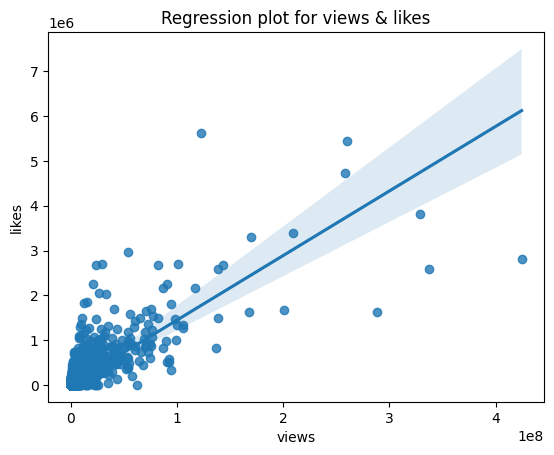

In [ ]:
import matplotlib.pyplot as plt
df = final_datset
# select the columns to plot
plot_df = df.select("views", "likes")

# convert the Spark dataframe to a Pandas dataframe
plot_df = plot_df.toPandas()

# convert the columns to numeric type
plot_df["views"] = pd.to_numeric(plot_df["views"])
plot_df["likes"] = pd.to_numeric(plot_df["likes"])

# create the scatter plot
#plt.scatter(x=plot_df["views"], y=plot_df["likes"], alpha=0.5)

sns.regplot(data=plot_df,x='views',y='likes')
plt.title('Regression plot for views & likes')

plt.show

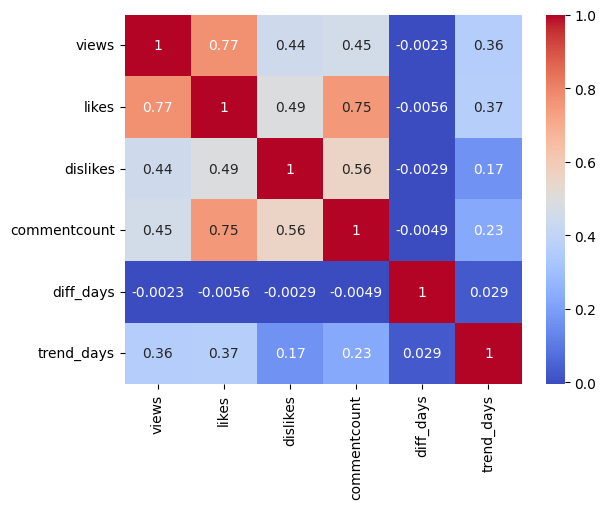

In [ ]:
# Create a heatmap to visualize the correlation between numerical columns
sns.heatmap(df.select("views", "likes", "dislikes", "commentcount", "diff_days", "trend_days").toPandas().corr(), annot=True, cmap="coolwarm")
plt.show()